Load and Explore Both Datasets

In [11]:
import pandas as pd

# Load both datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Shapes
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Preview
print("\nTrain Sample:")
display(train_df.head())

print("\nTest Sample:")
display(test_df.head())


KeyboardInterrupt: 

Explore Train Dataset (structure, missing values, class distribution)

In [ ]:
# Data info
print("Train Info:")
train_df.info()

# Missing values
print("\nMissing values in Train:")
print(train_df.isnull().sum())

# Check column names
print("\nTrain Columns:", train_df.columns)

# Check class distribution (assuming 'toxic' is the label column)
if 'toxic' in train_df.columns:
    print("\nToxic Class Distribution:")
    print(train_df['toxic'].value_counts(normalize=True))
else:
    print("❗ Check the label column name — is it 'toxic'?")


Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB

Missing values in Train:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Train Columns: Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

Toxic Class Distribution:
toxic
0    0.904156
1 

Check Test Dataset Structure

In [ ]:
# If test set has labels too
if 'toxic' in test_df.columns:
    print("\nTest Class Distribution:")
    print(test_df['toxic'].value_counts(normalize=True))
else:
    print("\nNo label column found in test.csv — used for prediction only.")



No label column found in test.csv — used for prediction only.


 Preprocessing and Tokenization

In [ ]:
import re
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)  # remove HTML tags
    text = re.sub(r"http\S+|www\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # remove special chars and numbers
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

# Apply cleaning
train_df['clean_text'] = train_df['comment_text'].apply(clean_text)

# Tokenization and padding
vocab_size = 10000
max_length = 150
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_df['clean_text'])

sequences = tokenizer.texts_to_sequences(train_df['clean_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Final input and label
X = padded_sequences
y = train_df['toxic'].values

print("Tokenized and Padded shape:", X.shape)


Tokenized and Padded shape: (159571, 150)


Split the Data and Build LSTM Model

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense

# Step 1: Build model
inputs = Input(shape=(150,))
x = Embedding(10000, 64)(inputs)
x = LSTM(64)(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 2: Train it again (optional if already trained)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=128)

# Step 3: Save in new safe format
model.save("lstm_model_final.keras")


Epoch 1/3
998/998 ━━━━━━━━━━━━━━━━━━━━ 92s 91ms/step - accuracy: 0.9022 - loss: 0.3348 - val_accuracy: 0.9042 - val_loss: 0.3142
Epoch 2/3
998/998 ━━━━━━━━━━━━━━━━━━━━ 95s 95ms/step - accuracy: 0.9036 - loss: 0.3135 - val_accuracy: 0.9053 - val_loss: 0.2271
Epoch 3/3
998/998 ━━━━━━━━━━━━━━━━━━━━ 125s 125ms/step - accuracy: 0.9147 - loss: 0.1946 - val_accuracy: 0.9501 - val_loss: 0.1379


Model Evaluation

998/998 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28859
           1       0.84      0.74      0.79      3056

    accuracy                           0.96     31915
   macro avg       0.91      0.86      0.88     31915
weighted avg       0.96      0.96      0.96     31915



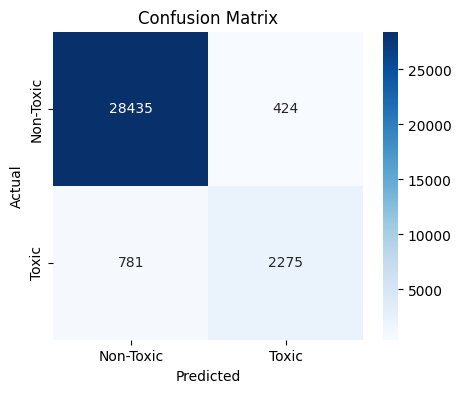

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on validation set
y_pred = (model.predict(X_val) > 0.5).astype("int32")

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Toxic", "Toxic"], yticklabels=["Non-Toxic", "Toxic"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Save the trained model and tokenizer

In [15]:
import pickle

# Save the trained model
model.save("lstm_model_final.keras")
print("✅ Model saved as 'lstm__model_final.keras'")

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("✅ Tokenizer saved as 'tokenizer.pkl'")


✅ Model saved as 'lstm__model_final.keras'
✅ Tokenizer saved as 'tokenizer.pkl'


## Summary and Next Steps

In this notebook, we developed a deep learning model using an LSTM architecture to classify toxic comments. We explored the dataset, preprocessed the text, trained and evaluated the model, and saved all necessary components for deployment.

Next steps include:
- Integrating the model into a Streamlit web application
- Performing real-time and batch predictions
- Visualizing prediction results